# Configs


## Libraries

In [ ]:
!pip install geopandas
!pip install libpysal

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 4.7 MB/s 
     |████████████████████████████████| 6.3 MB 48.8 MB/s 
     |████████████████████████████████| 16.7 MB 31.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.4 MB 5.0 MB/s 


In [ ]:
import geopandas as gpd
import libpysal
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

from matplotlib.lines import Line2D
from shapely.geometry import shape, mapping, Point, MultiPolygon, Polygon, LineString
from shapely.ops import transform, split
from shapely.validation import make_valid
from shapely.wkt import loads
from tqdm import tqdm

import warnings
warnings.simplefilter(action = "ignore", category = FutureWarning)
warnings.simplefilter(action = "ignore", category = UserWarning)

## Google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/Shareddrives/'NEXUS-PARSEC - TCCs'/ProjetoRaf-Car-Igor/Datasets/indicadores_IDH_Nexus
!ls *.csv 

/content/drive/Shareddrives/NEXUS-PARSEC - TCCs/ProjetoRaf-Car-Igor/Datasets/indicadores_IDH_Nexus
NEXUS_data_2010.csv  setores_nexus_2010.csv


## Projection


In [ ]:
MERCATOR_CRS = "EPSG:3857"  # Mercator projection CRS.
#METRIC_CRS = "EPSG:32634"   # Metric CRS. Useful for calculations
METRIC_CRS = {"proj":"cea"}
WGS84_CRS = "EPSG:4326"     # World Geodetic System
SIRGAS_CRS = "EPSG:4674"    # SIRGAS 2000, a projection for LATAM

PLOT_CRS = MERCATOR_CRS

In [ ]:
def change_projection(df, current_crs, new_crs):
  """
    Changes the projection of an GeoDataFrame
    Returns with new GeoDataFrame with centroid, area, geometry, lat and lon
    updated.
  """
  assert df.crs == current_crs
  df.geometry = df.geometry.to_crs(new_crs)
  df["centroid"] = df.geometry.centroid
  df["area"] = df.geometry.area
  df["lat"] = df['centroid'].map(lambda p: p.x)
  df["lon"] = df['centroid'].map(lambda p: p.y)
  return df

# Load Data

In [ ]:
DF_PATH = r"NEXUS_data_2010.csv"

In [ ]:
df = pd.read_csv(DF_PATH, sep = ",", quotechar = '"', encoding = "iso-8859-1")
df["TYPE"] = df["TIPO"].replace("URBANO", "URBAN") # Translate situation name to english
geo = gpd.GeoDataFrame(df, crs = MERCATOR_CRS, geometry = [loads(mpoly) for mpoly in df["WKT"]])
geo = geo.to_crs(METRIC_CRS)

In [ ]:
geo['centroid'] = geo.geometry.centroid
# Extract lat and lon from the centerpoint
geo["lat"] = geo['centroid'].map(lambda p: p.x)
geo["lon"] = geo['centroid'].map(lambda p: p.y)

geo["area"] = geo.geometry.area # Area in m2

geo.head()

,Unnamed: 0,year,Cod_setor,TIPO,Cod_municipio,Cod_estado,income,longevity,literacy,WKT,TYPE,geometry,centroid,lat,lon,area
0,0,2010,110030405000001,URBANO,1100304,11,0.800035,0.800000,0.996329,MultiPolygon (((-6694800.91148638 -1429885.364...,URBAN,"MULTIPOLYGON (((-6694800.911 -1397290.661, -66...",POINT (-6694600.249 -1397593.184),-6.694600e+06,-1.397593e+06,237969.552271
1,1,2010,110030405000002,URBANO,1100304,11,0.727118,0.766667,0.979336,MultiPolygon (((-6694910.44660865 -1430379.588...,URBAN,"MULTIPOLYGON (((-6694910.447 -1397758.004, -66...",POINT (-6694733.171 -1398041.242),-6.694733e+06,-1.398041e+06,231836.566193
2,2,2010,110030405000003,URBANO,1100304,11,0.732076,0.833333,0.964231,MultiPolygon (((-6695004.30229773 -1429829.110...,URBAN,"MULTIPOLYGON (((-6695004.302 -1397237.465, -66...",POINT (-6695036.221 -1397732.426),-6.695036e+06,-1.397732e+06,245979.041079
3,3,2010,110030405000004,URBANO,1100304,11,0.787907,0.766667,0.993087,MultiPolygon (((-6694625.03233981 -1429016.066...,URBAN,"MULTIPOLYGON (((-6694625.032 -1396468.607, -66...",POINT (-6694246.720 -1397006.028),-6.694247e+06,-1.397006e+06,911316.220515
4,4,2010,110030405000005,URBANO,1100304,11,0.642104,0.733333,0.947658,MultiPolygon (((-6695544.27307255 -1428781.091...,URBAN,"MULTIPOLYGON (((-6695544.273 -1396246.394, -66...",POINT (-6695123.949 -1396501.142),-6.695124e+06,-1.396501e+06,278661.472773


In [ ]:
geo["area"].sum()

3421927573887.578

# Sample Clusters
The images are going to be collected through the Google Earth Engine API by indicating each image centroid.
Three conditions must be met in order to avoid model bias: 
1. Each image represents only a single type (urban or rural)
2. The amount of rural and urban images is in the same proportion
3. Avoid the presence of the same region in more than one image.


## Plot Functions

In [ ]:
def plot_square(vertices : gpd.GeoSeries, axis, color = "blue", alpha = 0.8, linewidth = 1):
    """
        Takes a GeoSeries of four vertices and plots the corresponding square.
    """
    df_vertices = gpd.GeoDataFrame(geometry = vertices, crs = vertices.crs)
    for i in range(4):
        vertice_1 = df_vertices.loc[i].geometry
        vertice_2 = df_vertices.loc[(i + 1) % 4].geometry
        axis.plot([vertice_1.x, vertice_2.x], [vertice_1.y, vertice_2.y], alpha = alpha, linewidth = linewidth, color = color)

In [ ]:
def plot_cluster_coordinates(axis, centroid, crs = METRIC_CRS):
    """
        Plot the square centered on a given centroid.

        Usage example:
                fig, axis = plt.subplots(1,1, figsize=(20,20))
                plot_cluster_coordinates(df, sector_code, axis)
                axis.tick_params(
                                    axis='both', which='both',
                                    bottom=False, top=False, labelbottom=False,
                                    right=False, left=False, labelleft=False
                                )
                axis.legend()
                plt.show()
    """
    cluster = generate_centered_square_vertices(centroid)
    cluster = gpd.GeoSeries(cluster, crs = crs)
    plot_square(cluster, axis, color = "salmon", alpha = 0.8, linewidth = 1)


def plot_all_sector_centroids(axis, df):
    """
    """
    df_urban = df[df["TYPE"] == "URBAN"]
    df_rural = df[df["TYPE"] == "RURAL"]
    axis.scatter(x = df_urban['lat'], y = df_urban['lon'], alpha = 0.8, linewidth = 0.5, s = 15, color = "orange", label = "Urban")
    axis.scatter(x = df_rural['lat'], y = df_rural['lon'], alpha = 0.8, linewidth = 0.5, s = 15, color = "green", label = "Rural")


def plot_map(axis, df, color = "gray", alpha = 0.4, linewidth = 0.1):
    df["geometry"].plot(ax = axis, facecolor = color, alpha = alpha, edgecolor = 'black', linewidth = linewidth)


def plot_selected_centroids(axis, df, should_plot_cluster = False):
    """
        Plot the centroids of each selected cluster, its color either represents a RURAL or URBAN cluster.
        It is possible to plot the cluster box with the boolean should_plot_cluster.
        
        Inputs:
        - axis: matplotlib.pyplot image axis
        - df: geodataframe of selected clusters. Should containt "centroid", "TYPE", "lat", "lon" columns
        - should_plot_cluster [False]: boolean for plotting the cluster box

        Usage example:
                fig, axis = plt.subplots(1,1, figsize=(20,20))
                plot_selected_centroids(df, sector_code, axis)
                axis.tick_params(
                                    axis='both', which='both',
                                    bottom=False, top=False, labelbottom=False,
                                    right=False, left=False, labelleft=False
                                )
                axis.legend()
                plt.show()
    """
    if should_plot_cluster:
        for selected_cluster_centroid in df["centroid"].tolist():
            plot_cluster_coordinates(axis, selected_cluster_centroid, df.crs)

    df_urban = df[df["TYPE"] == "URBAN"]
    df_rural = df[df["TYPE"] == "RURAL"]
    
    axis.scatter(x = df_urban["lat"], y = df_urban["lon"], alpha = 0.8, linewidth = 0.5, s = 15, color = "blue", label = "Urban cluster")
    axis.scatter(x = df_rural["lat"], y = df_rural["lon"], alpha = 1.0, linewidth = 0.5, s = 15, color = "magenta", label = "Rural cluster")


def plot_data(axis, df, df_selected = None, should_plot_cluster = False, should_plot_all_centroids = False):
    legend_custom_text = []
    legend_custom_lines = []

    plot_map(axis, df)

    if df_selected is not None:
        plot_selected_centroids(axis, df_selected, should_plot_cluster)
        legend_custom_text.append("Selected Urban")
        legend_custom_lines.append(Line2D([0], [0], marker='o', markerfacecolor = "blue",
                                          markersize = 10, color = "blue", lw = 0))
        legend_custom_text.append("Selected Rural")
        legend_custom_lines.append(Line2D([0], [0], marker='o', markerfacecolor = "magenta",
                                          markersize = 10, color = "magenta", lw = 0))
        if should_plot_cluster:
            legend_custom_text.append("Cluster boundaries")
            legend_custom_lines.append(Line2D([0], [0], color = "salmon", lw = 2))
            

    if should_plot_all_centroids:
        plot_all_sector_centroids(axis, df)
        legend_custom_text.append("All urban sector centroids")
        legend_custom_lines.append(Line2D([0], [0], marker='o', markerfacecolor = "hotpink",
                                          markersize = 10, color = "hotpink", lw = 0))
        legend_custom_text.append("All rural sector centroids")
        legend_custom_lines.append(Line2D([0], [0], marker='o', markerfacecolor = "green",
                                          markersize = 10, color = "green", lw = 0))

    axis.tick_params(axis='both', which='both',
                     bottom=False, top=False, labelbottom=False,
                     right=False, left=False, labelleft=False
                    )

    axis.legend(legend_custom_lines, legend_custom_text)


def plot_municipality(axis, df, cod_mun, df_selected = None, should_plot_cluster = False, should_plot_all_centroids = False):
    df = df[df["Cod_municipio"] == cod_mun]

    if df_selected is not None:
        df_selected = df_selected[df_selected["Cod_municipio"] == cod_mun]

    plot_data(axis, df, df_selected, should_plot_cluster, should_plot_all_centroids)

In [ ]:
def plot_urban_neighbours_graph(axis, df, W):
    W.plot(df, ax = axis, color = "orange", 
           node_kws = {"marker": ''}, edge_kws = {"linewidth": 0.4, "alpha": 0.8})
    

def plot_urban_components(axis, df, W):
    components = W.component_labels
    combined_polygons = df.dissolve(by = components)
    plot_map(axis, combined_polygons, color = "gold")


def plot_mun_urban_selection_workflow(df, cod_mun, W):
    df_mun = df[df["Cod_municipio"] == cod_mun]
    df_urban = df_mun[df_mun["TYPE"] == "URBAN"].reset_index()

    plt.figure(figsize = (30,30))
    ax1 = plt.subplot(1,2,1)
    plot_municipality(ax1, df, cod_mun, should_plot_all_centroids = True)
    plot_urban_neighbours_graph(ax1, df_urban, W)

    # ax2 = plt.subplot(1,2,2)
    # plot_municipality(ax2, df, cod_mun, should_plot_all_centroids = True)
    # plot_urban_components(ax2, df_urban, W)
    # plot_urban_neighbours_graph(ax2, df_urban, W)

    plt.show()

In [ ]:
def plot_cluster_mesh(df_mun, df_urban, W, urban_mesh, cluster_mesh):
    legend_custom_text = []
    legend_custom_lines = []

    fig, axis = plt.subplots(1,1, figsize=(10,10))
    plot_map(axis, df_mun)
    plot_urban_components(axis, df_urban, W)

    # Plots the entirety of the urban mesh
    for vertices in urban_mesh:
        # print("mesh_vertices")
        vertices = gpd.GeoSeries(vertices, crs = df_mun.crs)
        # print(vertices)
        plot_square(vertices, axis, color="teal", alpha = 0.7, linewidth = 0.8)
    legend_custom_text.append("candidate clusters")
    legend_custom_lines.append(Line2D([0], [0], marker='o', markerfacecolor = 'teal',
                                          markersize = 10, color = "teal", lw = 0))
    
    # Plots only selected parts of the mesh, i.e. clusters
    for vertices in cluster_mesh:
        # print("cluster_vertices")
        vertices = gpd.GeoSeries(vertices, crs = df_mun.crs)
        # print(vertices)
        plot_square(vertices, axis, color="red", alpha = 0.7, linewidth = 1.2)
    legend_custom_text.append("selected clusters")
    legend_custom_lines.append(Line2D([0], [0], marker='o', markerfacecolor = 'red',
                                          markersize = 10, color = "red", lw = 0))
    
    plt.legend(legend_custom_lines, legend_custom_text)
    axis.set_title("Urban Grids")

    axis.tick_params(axis='both', which='both',
                     bottom=False, top=False, labelbottom=False,
                     right=False, left=False, labelleft=False
                    )

    plt.show()

## Option 1: Random Sampling
The first proposal is to take a random sample of each municipality’s tracts and define those as the center of a cluster.

First, we will separate each municipality and then count how many sectors there are in each of them.
We want to pick, for each municipality, only 25% of the geo sectors, keeping the balance of 50/50 between Rural and Urban sectors*.
If the balance is not possible, we only select an amount of sectors corresponding to the situation with the less amount.

Then, plot the selected sectors.

In [ ]:
geo["TYPE"].value_counts()

URBAN    78000
RURAL    36244
Name: TYPE, dtype: int64

*Obs: a more appropriate balance would be to consider the proportion between rural and urban tracts.

In [ ]:
geo.groupby("Cod_municipio")["TYPE"].value_counts()

Cod_municipio  TYPE 
1100304        URBAN      71
               RURAL      21
1502707        URBAN      44
               RURAL      31
1506583        RURAL      33
                        ... 
5222203        URBAN       4
5222302        RURAL      11
               URBAN       2
5300108        URBAN    4175
               RURAL     279
Name: TYPE, Length: 5011, dtype: int64

We split the dataset into two: one for URBAN and other for RURAL, then we check how many sectors are available for each municipality and do the selection.

When selecting the cluster centroid, we need to make sure that the image centered in that point does not overlap with another selected image. Otherwise, we just ignore the overlap.

### Workflow Functions

In [ ]:
def sample_sectors(df, MAX_ITERATION = 10):
    """
        Select a proportion of census tracts centroids randomly for each municipalities.
        Each centroid represents a cluster: a square of size 6.7 km.
        If there is overlap between selected clusters, try to resample (up to MAX_ITERATION times).
    """
    dataset = gpd.GeoDataFrame(None, crs = df.crs) # Create empty GeoDataFrame.
    total_attempts_per_municipality = {}

    for mun_code in df["Cod_municipio"].unique():
        df_mun = df[df["Cod_municipio"] == mun_code]
        total_to_select = calculate_total_sectors_per_type(df_mun)

        selected_sectors, total_attempts = sample_municipality_sectors(df_mun, total_to_select, MAX_ITERATION)
        total_attempts_per_municipality[mun_code] = total_attempts

        print(f"{mun_code}: total_attempts = {total_attempts}, Sectors selected = {selected_sectors.shape[0]}")

        dataset = gpd.GeoDataFrame(pd.concat([dataset, selected_sectors], ignore_index = True), crs = dataset.crs)
    return dataset


def calculate_total_sectors_per_type(df_mun, PROPORTION = 1/8):
    """
        Calculate the total of sectors to be selected per type ("URBAN" or "RURAL").
    """
    df_urban = df_mun[df_mun["TYPE"] == "URBAN"]
    df_rural = df_mun[df_mun["TYPE"] == "RURAL"]

    total_urban = df_urban.shape[0]
    total_rural = df_rural.shape[0]
    total_sectors = total_urban + total_rural
    total_to_select = int(total_sectors * PROPORTION)

    if total_urban < total_to_select or total_rural < total_to_select: 
        total_to_select = min(total_urban, total_rural)
    return total_to_select


def sample_municipality_sectors(df_mun, total_to_select, MAX_ITERATION = 10):
    """
        Sample sectors by type ("URBAN" or "RURAL") from a specified municipality, 
        trying to avoid overlapping between the clusters generated by each sector selected.
    """
    df_mun_urban, df_mun_rural = split_sectors_by_type(df_mun)
    selected_sectors = gpd.GeoDataFrame(None, crs = df_mun.crs) # Create empty GeoDataFrame.
    
    for i in range(1, MAX_ITERATION + 1):
        sel_urban = df_mun_urban.sample(n = total_to_select)
        sel_rural = df_mun_rural.sample(n = total_to_select)
        df_selected_sectors = gpd.GeoDataFrame(pd.concat([sel_urban, sel_rural], ignore_index = True), crs = selected_sectors.crs)
        if not evaluate_overlapping(df_mun, df_selected_sectors):
            return df_selected_sectors, i
    
    return df_selected_sectors, -1

  
def split_sectors_by_type(df_mun):
    """
        Split municipality dataframe according to type ("URBAN" or "RURAL").
    """
    df_mun_urban = df_mun[df_mun["TYPE"] == "URBAN"]
    df_mun_rural = df_mun[df_mun["TYPE"] == "RURAL"]
    return df_mun_urban, df_mun_rural


def evaluate_overlapping(df_mun, df_selected_sectors):
    """
        Analyze clusters formed by the selected sectors by listing all sectors that reside
        in those clusters and checking if they overlap.
    """
    clusters_by_internal_sectors = map_clusters_by_internal_sectors(df_mun, df_selected_sectors)
    sectors_overlapping = find_sectors_overlapping(clusters_by_internal_sectors, df_mun)
    if not sectors_overlapping:
      return False
    return True


def find_sectors_overlapping(clusters_by_internal_sectors, df_mun):
    """
        Check each sector inside the municipality, analyzing if it overlaps different clusters.
        Return a list of sectors overlapping.
    """
    sectors_overlapping = []
    for index, sector in df_mun.iterrows():
        if is_sector_overlapping(sector["Cod_setor"], clusters_by_internal_sectors):
            sectors_overlapping.append(sector) # TODO: fix this return to a better type, e.g. dataframe
    return sectors_overlapping


def is_sector_overlapping(sector_code, clusters_by_internal_sectors):
    """
        Check if a sector_code is inside 2 or more clusters.
    """
    try:
        if len(clusters_by_internal_sectors[sector_code].keys()) > 1:
          return True
        return False
    
    # In case the key does not exist
    except:
      return False


def map_clusters_by_internal_sectors(df_mun, df_selected_sectors):
    """
        Find all sectors that reside in at least one cluster and return a dictionary
        containing this information.
    """
    clusters_by_internal_sectors = {}
    for index, sector in df_selected_sectors.iterrows():
        cluster = generate_centered_square_vertices(sector["centroid"])
        clusters_by_internal_sectors = find_map_of_sectors(df_mun, sector["Cod_setor"], cluster, clusters_by_internal_sectors)
    return clusters_by_internal_sectors


def find_map_of_sectors(df_mun, selected_sector_code, cluster, clusters_by_internal_sectors):
    """
        Generate a dictionary where keys are the Cod_setor of sectors that reside in
        at least one cluster determined by df_selected_sectors and the value is a dictionary
        that lists all the clusters where the sector resides.
    """
    # TODO: this may be faster by mapping centroids with a function, creating a df of only sectors inside the cluster
    for index, sector in df_mun.iterrows():
        if is_sector_inside_cluster(cluster, sector):
            clusters = clusters_by_internal_sectors.get(sector["Cod_setor"], {})
            clusters[selected_sector_code] = True
            clusters_by_internal_sectors[sector["Cod_setor"]] = clusters
    return clusters_by_internal_sectors


def is_sector_inside_cluster(cluster, sector):
    """
        Check if the sector centroid is inside the cluster.
    """
    centroid = sector
    if type(centroid) != Point:
      centroid = sector["centroid"]
    min_x = min([vertice.x for vertice in cluster])
    max_x = max([vertice.x for vertice in cluster])
    min_y = min([vertice.y for vertice in cluster])
    max_y = max([vertice.y for vertice in cluster])
    if centroid.x >= min_x and centroid.x <= max_x:
        if centroid.y >= min_y and centroid.y <= max_y:
            return True
    return False



def generate_centered_square_vertices(centroid, crs = MERCATOR_CRS, sqr_size = 6.7e3):
    """
        Generate a square centered on centroid = centroid [Point(x,y)] with size = sqr_size, in meters.
        Returns the square vertices as a list.
    """
    df_centroid = gpd.GeoDataFrame(geometry = gpd.GeoSeries(centroid, crs = crs))

    x = df_centroid["geometry"].x
    y = df_centroid["geometry"].y

    p1 = Point((x - sqr_size / 2, y - sqr_size / 2)) # Bottom Left
    p2 = Point((x + sqr_size / 2, y - sqr_size / 2)) # Bottom Right
    p3 = Point((x + sqr_size / 2, y + sqr_size / 2)) # Top Right
    p4 = Point((x - sqr_size / 2, y + sqr_size / 2)) # Top Left
    vertices = [p1, p2, p3, p4]
    
    return vertices

### Execution

Municipality Code  | Total urban tracts | Total rural tracts | Selected tracts | Observation 
-------------------|------------------|-------------------|-------------------|-------------------
2700904    |1|9|2|Works Fine 
2701506    |5|7|2|Works Fine 
2701803    |4|4|2|Works Fine 
2703403    |2|5|0|Municipality has less then 8 census tracts 
2703700    |3|4|0|Municipality has less then 8 census tracts
3546256    |5|2|0|Municipality has less then 8 census tracts
2700102    |5|18|4|Can't sample without overlap 
2910800    |577|77|154|Can't sample without overlap 
2700300    |180|54|58|Can't sample without overlap

In [ ]:
#[2700300, 2910800, 3546256, 2700102, 2700904, 2701506, 2701803, 2703403, 2703700]
cod_mun = 2910800
df_test = geo[geo["Cod_municipio"].isin([cod_mun])]

In [ ]:
dataset = sample_sectors(df_test, MAX_ITERATION = 5)

2910800: total_attempts = -1, Sectors selected = 154


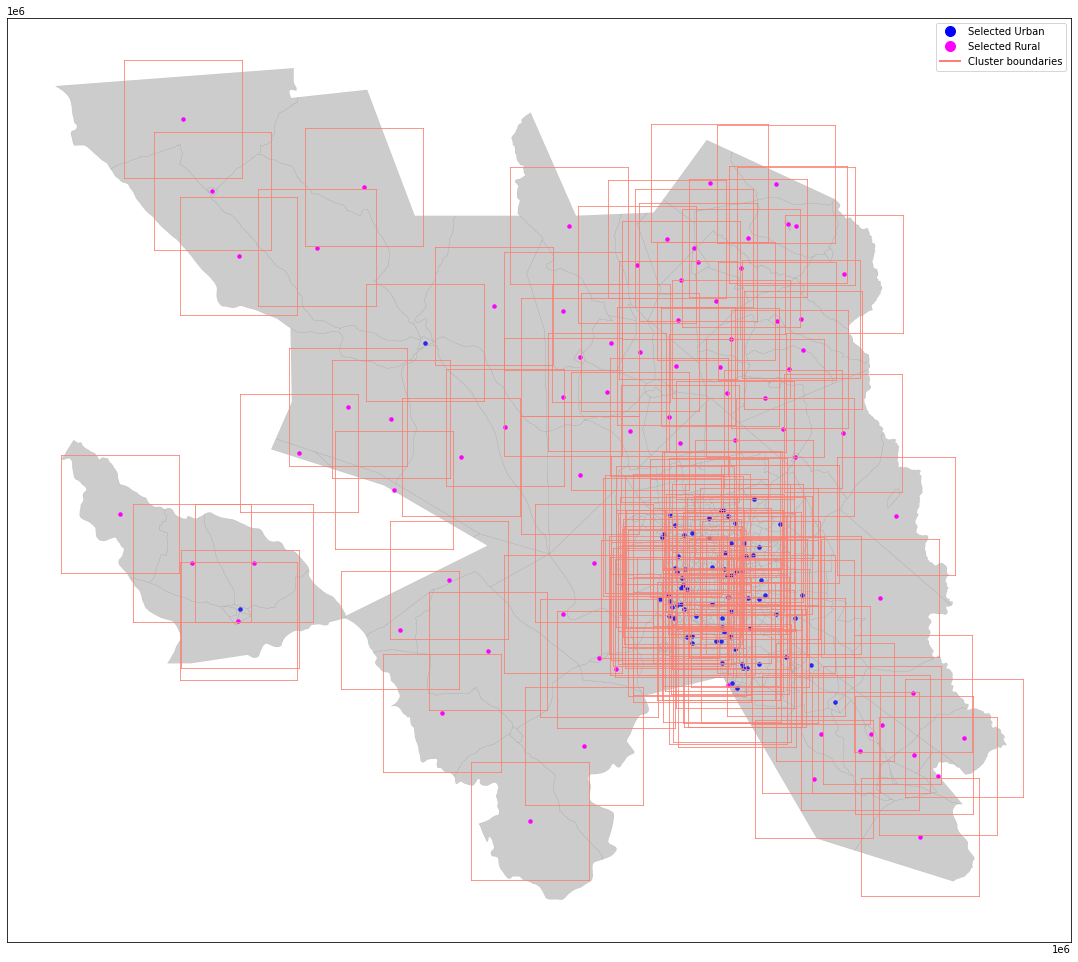

In [ ]:
plt.figure(figsize = (30,30))

ax1 = plt.subplot(1,2,1)
# plot_municipality(ax1, geo, cod_mun, should_plot_all_centroids = True)
# plt.title(f"All census tracts of {cod_mun}")


# ax2 = plt.subplot(1,2,2)
plot_municipality(ax1, geo, cod_mun, dataset, should_plot_cluster = True)

plt.tight_layout()

plt.show()


For many cases, the urban sectors will be so close to each other that it will be almost impossible to sample a good amount of random clusters without overlaps.

## Option 2: Neighbouring Clusters
This option proposes to merge neighbouring urban sectors into a single group and tries to fit clusters in these groups.

The urban groups are created through an algorithm that computes a disconnected graph which maps the adjacency of urban tracts in the entire municipality.
Each subgraph is then merged to create a single polygon and all possible clusters are fitted into this new form. A cluster will fit the polygon if at least 70% of its area is filled with urban tracts.

### Workflow Functions

In [ ]:
def compute_weight_matrix(df):
    """
      Create weight matrix
    """
    W = libpysal.weights.Rook.from_dataframe(df)
    return W


def dissolve_groups(df, W):
    """
      Dissolves DataFrame's neighbouring polygons into a single one
    """
    components = W.component_labels
    combined_polygons = df.dissolve(by = components)
    return combined_polygons


def create_mesh_centroids(df, side_length, threshold, reduction_factor = 1.0):
    df = df.reset_index(drop = True)

    area = df.area.loc[0]
    cluster_area = side_length ** 2
    
    if threshold * cluster_area <= area < 2 * threshold * cluster_area:
      return [df.centroid.loc[0]]
    
    else:
      mesh_bounds = df.bounds
      side_length *= reduction_factor # Reduce approximation error
      return split_rectangle(mesh_bounds, side_length)


def create_meshes_and_clusters(df, side_length = 6.7e3, threshold = 0.70, reduction_factor = 1.0):
    """
      Create meshes on top of each group
      Find clusters on these meshes
    """
    mesh_vertices = []
    cluster_vertices = []
    # Iterates each DataFrame Polygon
    for row in range(df.shape[0]):
        df_group = df.iloc[row:row + 1] # Get row as DataFrame, instead of Series
        
        possible_cluster_centroids = create_mesh_centroids(
                                        df_group,
                                        side_length,
                                        threshold,
                                        reduction_factor = reduction_factor
                                      )
        
        possible_cluster_vertices = list(
            map(
              lambda centroid: generate_centered_square_vertices(
                                centroid,
                                sqr_size = side_length * reduction_factor,
                                crs = df.crs
                              ),
              possible_cluster_centroids
            )
          )
        mesh_vertices.extend(possible_cluster_vertices)
        
        for centroid in possible_cluster_centroids:
          vertices = generate_centered_square_vertices(centroid, crs = df.crs)
          if is_cluster_inside_group(vertices, df_group, threshold):
            cluster_vertices.append(vertices)
            
    return mesh_vertices, cluster_vertices


def neighbouring_clusters(df_mun, df_type, threshold = 0.7, reduction_factor = 1.0, plot = False):
    """
    How does it work?
      (1) Create weight matrix - compute_weight_matrix;
      (2) Dissolve DataFrame's neighbouring polygons into a single one - dissolve_groups;
      (3) Create meshes on top of each polygon - create_meshes_and_clusters;
      (PLOT) OPTIONAL - plot_cluster_mesh.
    """
    W = compute_weight_matrix(df_type)
    df_groups = dissolve_groups(df_type, W)
    mesh_vertices, cluster_vertices = create_meshes_and_clusters(
                                        df_groups,
                                        threshold = threshold,
                                        reduction_factor = reduction_factor
                                      )
    if plot:
      plot_cluster_mesh(df_mun, df_type, W, mesh_vertices, cluster_vertices)

    return mesh_vertices, cluster_vertices


def split_rectangle(rectangle, sqr_length = 6.7e3):
    """
        Take a large rectangle and split it into smaller squares of given length.
        Return a list of points that represent the centroid of each square of the 
        grid (segmented rectangle).
    """
    maxx = rectangle.maxx.loc[0]
    minx = rectangle.minx.loc[0]
    maxy = rectangle.maxy.loc[0]
    miny = rectangle.miny.loc[0]
    
    h_ticks = np.arange(minx, maxx + sqr_length / 2, sqr_length)
    v_ticks = np.arange(miny, maxy + sqr_length / 2, sqr_length)

    cluster_centroids = []
    for h in range(len(h_ticks) - 1):
        left = h_ticks[h]
        right = h_ticks[h + 1]
        for v in range(len(v_ticks) - 1):
            bottom = v_ticks[v]
            top = v_ticks[v + 1]          
            centroid = Point((left + right) / 2, (top + bottom) / 2)
            cluster_centroids.append(centroid)
      
    return cluster_centroids


def is_cluster_inside_group(cluster_vertices, df_group, area_threshold):
    """
        Check if the area of a cluster is mainly composed of the group census tracts.
        The threshold for the analysis is determined by area_threshold.
    """
    df_group = df_group.reset_index(drop = True)


    df_cluster_polygon = convert_vertices_to_polygon(cluster_vertices)
    df_intersection = calculate_intersection_polygon(df_cluster_polygon, df_group)
    
    cluster_area = df_cluster_polygon.area[0]
    intersection_area = df_intersection.area[0]

    return intersection_area/cluster_area >= area_threshold


def convert_vertices_to_polygon(vertices, crs = METRIC_CRS):
    """
        Get a list (or GeoSeries) of 4 points (vertices) and generate a
        GeoDataFrame containing a polygon represented by those vertices.
    """
    polygon = Polygon([(vertice.x, vertice.y) for vertice in vertices])
    return gpd.GeoDataFrame(geometry = gpd.GeoSeries(polygon), crs = crs)


def calculate_intersection_polygon(df_polygon_1, df_polygon_2):
    """
        Get two GeoDataFrames containing a Polygon each and calculate a third
        GeoDataFrame containing the intersection of those two, represented by an
        intersection Polygon.
    """
    try:
      intersection_polygon = df_polygon_1.intersection(df_polygon_2.geometry)
      return gpd.GeoDataFrame(geometry = gpd.GeoSeries(intersection_polygon), 
                                        crs = df_polygon_1.crs)
    except:
      df_polygon_2["geometry"] = make_valid(df_polygon_2["geometry"].loc[0])
      return calculate_intersection_polygon(df_polygon_1, df_polygon_2)


def calculate_cluster_centroid(cluster_vertices):
    """
        Get 4 vertices of a square and calculate its centroid.
    """
    # x = (bottomleft.X  + bottomright.X)/2
    # y = (bottomright.Y +    topright.Y)/2
    x = (cluster_vertices[0].x + cluster_vertices[1].x) / 2
    y = (cluster_vertices[1].y + cluster_vertices[2].y) / 2
    return Point((x, y))

# Create the dataset

Adding a few more functions to use this method to create the dataset, i.e. using the centroids to calculate the data needed to define each cluster.

In [ ]:
geo.head(1)

,Unnamed: 0,year,Cod_setor,TIPO,Cod_municipio,Cod_estado,income,longevity,literacy,WKT,TYPE,geometry,centroid,lat,lon,area
0,0,2010,110030405000001,URBANO,1100304,11,0.800035,0.8,0.996329,MultiPolygon (((-6694800.91148638 -1429885.364...,URBAN,"MULTIPOLYGON (((-6694800.911 -1397290.661, -66...",POINT (-6694600.249 -1397593.184),-6.694600e+06,-1.397593e+06,237969.552271


In [ ]:
def sample_clusters(cluster_vertices, number_of_clusters):
  return random.sample(cluster_vertices, number_of_clusters)


def intersection(poly1, poly2):
  """
    Calculates the ratio between intersection area and poly1 area.
    returns (POLY1 ∩ POLY2)/POLY1
  """
  return poly1.intersection(poly2).area/poly1.area


def find_tracts_inside_cluster(df_type, cluster_vertices):
  cluster_poly = convert_vertices_to_polygon(cluster_vertices, df_type.crs).loc[0].geometry
  weight_series = df_type.geometry.apply(
      lambda poly: intersection(poly, cluster_poly)).rename("intersection")
  df_tracts = pd.concat([df_type, weight_series], axis=1)
  return df_tracts


def weight_value(value, weight):
  return value*weight


def weighted_avg(df, value_column, weight_column):
  w_values = df[[value_column, weight_column]].apply(
                lambda row: weight_value(row[value_column], row[weight_column]),
                axis=1
             )
  w_avg = w_values.sum()/df[weight_column].sum()
  return w_avg


def create_cluster_data(df_tracts, cluster_vertices):
  """
    The value of indicators (literacy, longevity, income) is calculated by the
    weighted average with some metric value as weight.
    Centroid is calculated using cluster vertices.
    Other metadata is separated by their unique values.
  """
  # cluster_centroid = calculate_cluster_centroid(cluster_vertices)
  # print(f"cluster_centroid = {cluster_centroid}")
  cluster_polygon  = convert_vertices_to_polygon(cluster_vertices, df_tracts.crs).loc[0].geometry
  cluster_centroid = cluster_polygon.centroid
  cluster_data = {
      "literacy" : weighted_avg(df_tracts, "literacy", "intersection"),
      "longevity": weighted_avg(df_tracts, "longevity", "intersection"),
      "income"   : weighted_avg(df_tracts, "income", "intersection"),
      "centroid" : cluster_centroid,
      "geometry" : cluster_polygon,
      "lat"      : cluster_centroid.x,
      "lon"      : cluster_centroid.y,
      "year"     : df_tracts["year"].unique(),
      "TYPE"     : df_tracts["TYPE"].unique(),
      "Cod_municipio" : df_tracts["Cod_municipio"].unique(),
      "Cod_estado" : df_tracts["Cod_estado"].unique()
  }
  # print(cluster_data)
  df_cluster = gpd.GeoDataFrame(data = cluster_data, crs = df_tracts.crs)
  return df_cluster  


def create_municipality_subset(df_mun):
  """
    Take the DataFrame for a municipality, and:
    (1) Calculate the number of clusters that can be selected based on the
        number of urban and rural tracts
    (2) Compute urban clusters through the Neighbouring Clusters method.
    (3) Assert whether the method above has the required number of clusters.
         - Update the number of clusters if it does not
    (4) Select found urban clusters randomly
    (5) For each selected urban cluster, compute which tracts are inside it, and
        then calculate the value of indicators based on these tracts.
  """
  cod_mun = df_mun["Cod_municipio"].unique()[0]
  df_urban = df_mun[df_mun["TYPE"] == "URBAN"].reset_index()

  # print(f' [INFO] Computing subset for Municipality Code: {cod_mun}.')
  number_of_clusters_per_type = calculate_total_sectors_per_type(df_mun)
  if number_of_clusters_per_type == 0:
    return None
  mesh_vertices, cluster_vertices = neighbouring_clusters(df_urban)
  # print(f' [INFO] Based on number of tracts, expected {number_of_clusters_per_type} clusters of each type.')
  number_of_clusters_per_type = min(number_of_clusters_per_type, len(cluster_vertices))
  # print(f' [INFO] Neighbouring clusters method found {len(cluster_vertices)} urban clusters.')
  cluster_vertices = sample_clusters(cluster_vertices, number_of_clusters_per_type)

  df_mun_subset = gpd.GeoDataFrame(data=None, crs=df_mun.crs)

  # Routine to gather urban clusters:
  for v in cluster_vertices:
    v = gpd.GeoSeries(v, crs = METRIC_CRS).to_crs(df_mun.crs)
    df_tracts = find_tracts_inside_cluster(df_urban, v)
    df_cluster = create_cluster_data(df_tracts, v)
    df_mun_subset = gpd.GeoDataFrame(pd.concat([df_mun_subset, df_cluster], ignore_index = True), crs = df_mun.crs)

  # Ro
  return df_mun_subset


In [ ]:
def create_dataset(df, reduction_factor = 1.0, should_balance_types = False, should_plot = False):
  """
    Take the DataFrame for the entire area and:
    (1) Compute all urban clusters;
    (2) Compute all rural clusters;
    (3) Compare the number of urban and rural clusters;
    (4) Sample the biggest group to match the amount of the smallest.
  """
  df_urban_subset = create_type_subset(df, "URBAN", reduction_factor, threshold = 0.6, should_plot = should_plot)
  total_urban_clusters = df_urban_subset.shape[0]
  
  df_rural_subset = create_type_subset(df, "RURAL", reduction_factor, threshold = 0.9, should_plot = should_plot)
  total_rural_clusters = df_rural_subset.shape[0]

  if should_balance_types:
    if total_urban_clusters > total_rural_clusters:
      print(f"There are too many URBAN clusters: {total_urban_clusters}")
      print(f"Sample URBAN set to match RURAL total: {total_rural_clusters}")
      df_urban_subset = df_urban_subset.sample(total_rural_clusters)

    elif total_rural_clusters > total_urban_clusters:
      print(f"There are many too RURAL clusters: {total_rural_clusters}")
      print(f"Sample RURAL set to match URBAN total: {total_urban_clusters}")
      df_rural_subset = df_rural_subset.sample(total_urban_clusters)

  df_dataset = gpd.GeoDataFrame(
      pd.concat([df_urban_subset, df_rural_subset], ignore_index = True),
      crs = df.crs
    )

  return df_dataset


def create_type_subset(df, sector_type, reduction_factor = 1.0, threshold = 0.7, should_plot = False):
  """
    Take the DataFrame for the entire area and:
    (1) For each municipality, compute clusters with target value
    for the given sector_type.
  """
  print(f"\n[{sector_type}] Calculating {sector_type} subset")

  municipalities = df["Cod_municipio"].unique()
  df_type_subset = gpd.GeoDataFrame(data = None, crs = df.crs)

  for cod_mun in tqdm(municipalities):
    df_mun = df[df["Cod_municipio"] == cod_mun].reset_index(drop = True)

    df_mun_type_subset = create_municipality_type_subset(df_mun, sector_type, threshold, reduction_factor, should_plot = should_plot)

    if df_mun_type_subset is not None:
      df_type_subset = gpd.GeoDataFrame(
          pd.concat([df_type_subset, df_mun_type_subset], ignore_index = True),
          crs = df.crs
        )
      
  print(f"\n[{sector_type}] Total {sector_type} samples: {df_type_subset.shape[0]}")
  return df_type_subset


def create_municipality_type_subset(df_mun, sector_type, threshold, reduction_factor = 1.0, should_plot = False):
  """
    Take the DataFrame for a municipality and:
    (1) Compute clusters for the given sector_type through the Neighbouring Clusters method;
    (2) For each selected cluster, compute which tracts are inside it;
    (3) For each selected cluster, calculate the value of indicators based on these tracts.

    sector_type is either "URBAN" or "RURAL".
  """
  df_type = df_mun[df_mun["TYPE"] == sector_type].reset_index()

  if df_type.shape[0] <= 0:
    return None

  mesh_vertices, cluster_vertices = neighbouring_clusters(
      df_mun,
      df_type,
      threshold = threshold,
      reduction_factor = reduction_factor,
      plot = should_plot
    )
  
  df_mun_subset = gpd.GeoDataFrame(data = None, crs = df_mun.crs)
  for v in cluster_vertices:
    df_tracts = find_tracts_inside_cluster(df_type, v)
    df_cluster = create_cluster_data(df_tracts, v)
    df_mun_subset = gpd.GeoDataFrame(
        pd.concat([df_mun_subset, df_cluster], ignore_index = True),
        crs = df_mun.crs
      )

  return df_mun_subset

In [ ]:
# 2910800 5002704
cod_mun = 5002704
df_example = geo[geo["Cod_municipio"] == cod_mun]
df_example_urban = df_example[df_example["TYPE"] == "URBAN"]

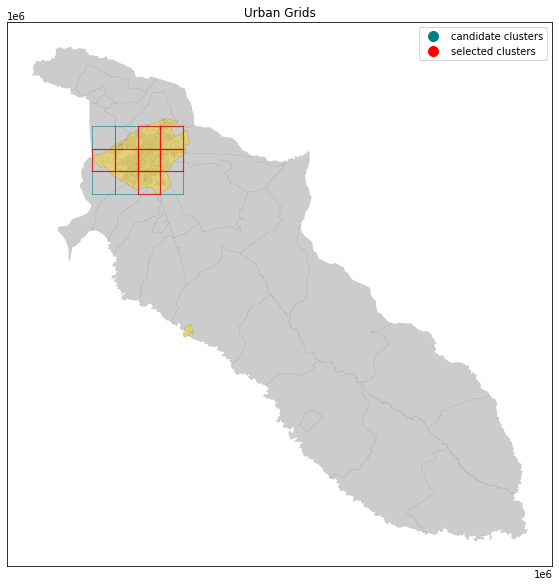

,literacy,longevity,income,centroid,geometry,lat,lon,year,TYPE,Cod_municipio,Cod_estado
0,0.778264,0.478040,0.411424,POINT (-6092732.939675751 -2218910.214775689),"POLYGON ((-6096082.940 -2222260.215, -6089382....",-6.092733e+06,-2.218910e+06,2010,URBAN,5002704,50
1,0.955567,0.677616,0.595857,POINT (-6086032.939675751 -2218910.214775689),"POLYGON ((-6089382.940 -2222260.215, -6082682....",-6.086033e+06,-2.218910e+06,2010,URBAN,5002704,50
2,0.955338,0.635518,0.559142,POINT (-6079332.939675751 -2225610.214775689),"POLYGON ((-6082682.940 -2228960.215, -6075982....",-6.079333e+06,-2.225610e+06,2010,URBAN,5002704,50
3,0.971328,0.762395,0.713181,POINT (-6079332.939675751 -2218910.214775689),"POLYGON ((-6082682.940 -2222260.215, -6075982....",-6.079333e+06,-2.218910e+06,2010,URBAN,5002704,50
4,0.976523,0.749082,0.712775,POINT (-6079332.939675751 -2212210.214775689),"POLYGON ((-6082682.940 -2215560.215, -6075982....",-6.079333e+06,-2.212210e+06,2010,URBAN,5002704,50
5,0.939655,0.652713,0.614611,POINT (-6072632.939675751 -2218910.214775689),"POLYGON ((-6075982.940 -2222260.215, -6069282....",-6.072633e+06,-2.218910e+06,2010,URBAN,5002704,50
6,0.952704,0.643844,0.633236,POINT (-6072632.939675751 -2212210.214775689),"POLYGON ((-6075982.940 -2215560.215, -6069282....",-6.072633e+06,-2.212210e+06,2010,URBAN,5002704,50


In [ ]:
create_municipality_type_subset(df_example, "URBAN", 0.6, should_plot=True)

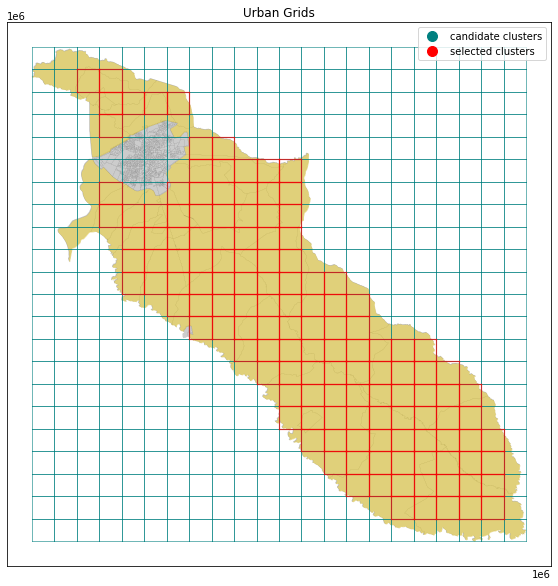

,literacy,longevity,income,centroid,geometry,lat,lon,year,TYPE,Cod_municipio,Cod_estado
0,0.926919,0.764345,0.614211,POINT (-6097305.973823811 -2194741.64449896),"POLYGON ((-6100655.974 -2198091.644, -6093955....",-6.097306e+06,-2.194742e+06,2010,RURAL,5002704,50
1,0.892199,0.646133,0.534867,POINT (-6090605.973823811 -2234941.64449896),"POLYGON ((-6093955.974 -2238291.644, -6087255....",-6.090606e+06,-2.234942e+06,2010,RURAL,5002704,50
2,0.896797,0.641261,0.569352,POINT (-6090605.973823811 -2228241.64449896),"POLYGON ((-6093955.974 -2231591.644, -6087255....",-6.090606e+06,-2.228242e+06,2010,RURAL,5002704,50
3,0.960848,0.705658,0.623340,POINT (-6090605.973823811 -2208141.64449896),"POLYGON ((-6093955.974 -2211491.644, -6087255....",-6.090606e+06,-2.208142e+06,2010,RURAL,5002704,50
4,0.915519,0.678615,0.574859,POINT (-6090605.973823811 -2201441.64449896),"POLYGON ((-6093955.974 -2204791.644, -6087255....",-6.090606e+06,-2.201442e+06,2010,RURAL,5002704,50
...,...,...,...,...,...,...,...,...,...,...,...
133,0.896909,0.488936,0.570304,POINT (-5983405.973823811 -2288541.64449896),"POLYGON ((-5986755.974 -2291891.644, -5980055....",-5.983406e+06,-2.288542e+06,2010,RURAL,5002704,50
134,0.944020,0.466667,0.597373,POINT (-5976705.973823811 -2322041.64449896),"POLYGON ((-5980055.974 -2325391.644, -5973355....",-5.976706e+06,-2.322042e+06,2010,RURAL,5002704,50
135,0.938612,0.466667,0.574354,POINT (-5976705.973823811 -2315341.64449896),"POLYGON ((-5980055.974 -2318691.644, -5973355....",-5.976706e+06,-2.315342e+06,2010,RURAL,5002704,50
136,0.935127,0.466667,0.559520,POINT (-5976705.973823811 -2308641.64449896),"POLYGON ((-5980055.974 -2311991.644, -5973355....",-5.976706e+06,-2.308642e+06,2010,RURAL,5002704,50


In [ ]:
create_municipality_type_subset(df_example, "RURAL", 0.9, should_plot=True)

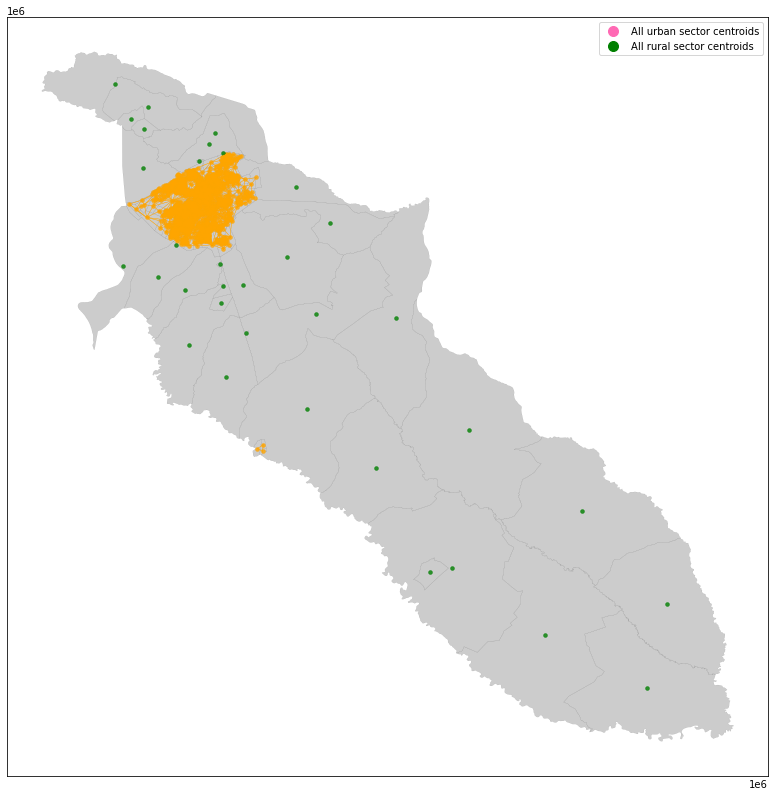

In [ ]:
W = compute_weight_matrix(df_example_urban)
plot_mun_urban_selection_workflow(df_example, cod_mun, W)

The program will go through each municipality defining all rural and urban clusters with "Neighbouring Clusters".

In [ ]:
df_dataset = create_dataset(geo)


[URBAN] Calculating URBAN subset


100%|██████████| 2512/2512 [02:39<00:00, 15.76it/s]



[URBAN] Total URBAN samples: 438

[RURAL] Calculating RURAL subset


100%|██████████| 2512/2512 [1:00:40<00:00,  1.45s/it]


[RURAL] Total RURAL samples: 52631


Now, we need to convert the dataset to a CRS that has an lat/lon method

In [ ]:
df_dataset = change_projection(df_dataset, METRIC_CRS, WGS84_CRS)

Add country column

In [ ]:
df_dataset["country"] = "brazil"

Save all clusters in a csv file, disconsidering imbalance between types.

In [ ]:
df_dataset.to_csv("dataset_all_clusters.csv")

In [ ]:
df_dataset.head()

,literacy,longevity,income,centroid,geometry,lat,lon,year,TYPE,Cod_municipio,Cod_estado,area,country
0,0.963506,0.768335,0.628482,POINT (-60.10067 -12.77281),"POLYGON ((-60.13076 -12.80386, -60.07058 -12.8...",-60.100669,-12.772811,2010,URBAN,1100304,11,0.003737,brazil
1,0.903346,0.758552,0.520860,POINT (-48.27024 -7.21817),"POLYGON ((-48.30033 -7.24871, -48.24014 -7.248...",-48.270235,-7.218174,2010,URBAN,1702109,17,0.003675,brazil
2,0.926798,0.781569,0.580544,POINT (-48.21005 -7.15711),"POLYGON ((-48.24014 -7.18764, -48.17995 -7.187...",-48.210048,-7.157114,2010,URBAN,1702109,17,0.003675,brazil
3,0.907821,0.790722,0.476975,POINT (-49.16213 -11.89274),"POLYGON ((-49.19223 -11.92369, -49.13204 -11.9...",-49.162132,-11.892742,2010,URBAN,1703867,17,0.003725,brazil
4,0.932752,0.778629,0.543212,POINT (-48.46886 -8.06231),"POLYGON ((-48.49895 -8.09290, -48.43876 -8.092...",-48.468856,-8.062309,2010,URBAN,1705508,17,0.003682,brazil


In [ ]:
df_dataset.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 53069 entries, 0 to 53068
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   literacy       53069 non-null  float64 
 1   longevity      53069 non-null  float64 
 2   income         53069 non-null  float64 
 3   centroid       53069 non-null  geometry
 4   geometry       53069 non-null  geometry
 5   lat            53069 non-null  float64 
 6   lon            53069 non-null  float64 
 7   year           53069 non-null  int64   
 8   TYPE           53069 non-null  object  
 9   Cod_municipio  53069 non-null  int64   
 10  Cod_estado     53069 non-null  int64   
 11  area           53069 non-null  float64 
 12  country        53069 non-null  object  
dtypes: float64(6), geometry(2), int64(3), object(2)
memory usage: 5.3+ MB


In [ ]:
df_dataset.describe()

,literacy,longevity,income,lat,lon,year,Cod_municipio,Cod_estado,area
count,53069.000000,53069.000000,53069.000000,53069.000000,53069.000000,53069.0,5.306900e+04,53069.000000,53069.000000
mean,0.787286,0.700759,0.462287,-48.234114,-13.194441,2010.0,3.593968e+06,35.820441,0.003758
std,0.210201,0.167125,0.158449,5.947881,4.871149,0.0,1.337208e+06,13.395889,0.000075
min,0.000000,0.000000,0.000000,-60.779908,-24.972324,2010.0,1.100304e+06,11.000000,0.003650
25%,0.733500,0.666928,0.369244,-53.100742,-16.959720,2010.0,2.305332e+06,23.000000,0.003697
50%,0.846593,0.746240,0.482770,-47.769825,-13.216726,2010.0,3.131703e+06,31.000000,0.003744
75%,0.924925,0.791319,0.586345,-43.620437,-9.550636,2010.0,5.102702e+06,51.000000,0.003808
max,1.000000,1.000000,1.000000,-35.182600,-2.279904,2010.0,5.300108e+06,53.000000,0.004013


In [ ]:
df_dataset_urban = df_dataset[df_dataset["TYPE"] == "URBAN"]
df_dataset_rural = df_dataset[df_dataset["TYPE"] == "RURAL"]

Create a balanced dataset 

In [ ]:
rural_total = 20000
df_dataset_rural_sample = df_dataset_rural.sample(rural_total)

df_dataset_balanced = gpd.GeoDataFrame(
        pd.concat([df_dataset_urban, df_dataset_rural_sample], ignore_index = True),
        crs = df_dataset.crs
      )

In [ ]:
df_dataset_balanced.to_csv("dataset.csv")

In [ ]:
df_dataset_balanced_clean = df_dataset_balanced[["country", "lat", "lon", "literacy", "longevity", "income", "year", "TYPE"]]
df_dataset_balanced_clean.head()

,country,lat,lon,literacy,longevity,income,year,TYPE
0,brazil,-60.100669,-12.772811,0.963506,0.768335,0.628482,2010,URBAN
1,brazil,-48.270235,-7.218174,0.903346,0.758552,0.520860,2010,URBAN
2,brazil,-48.210048,-7.157114,0.926798,0.781569,0.580544,2010,URBAN
3,brazil,-49.162132,-11.892742,0.907821,0.790722,0.476975,2010,URBAN
4,brazil,-48.468856,-8.062309,0.932752,0.778629,0.543212,2010,URBAN


In [ ]:
df_dataset_balanced_clean.to_csv("dataset_clean.csv")

In [ ]:
df_dataset_balanced.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 20438 entries, 0 to 20437
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   literacy       20438 non-null  float64 
 1   longevity      20438 non-null  float64 
 2   income         20438 non-null  float64 
 3   centroid       20438 non-null  geometry
 4   geometry       20438 non-null  geometry
 5   lat            20438 non-null  float64 
 6   lon            20438 non-null  float64 
 7   year           20438 non-null  int64   
 8   TYPE           20438 non-null  object  
 9   Cod_municipio  20438 non-null  int64   
 10  Cod_estado     20438 non-null  int64   
 11  area           20438 non-null  float64 
 12  country        20438 non-null  object  
dtypes: float64(6), geometry(2), int64(3), object(2)
memory usage: 2.0+ MB


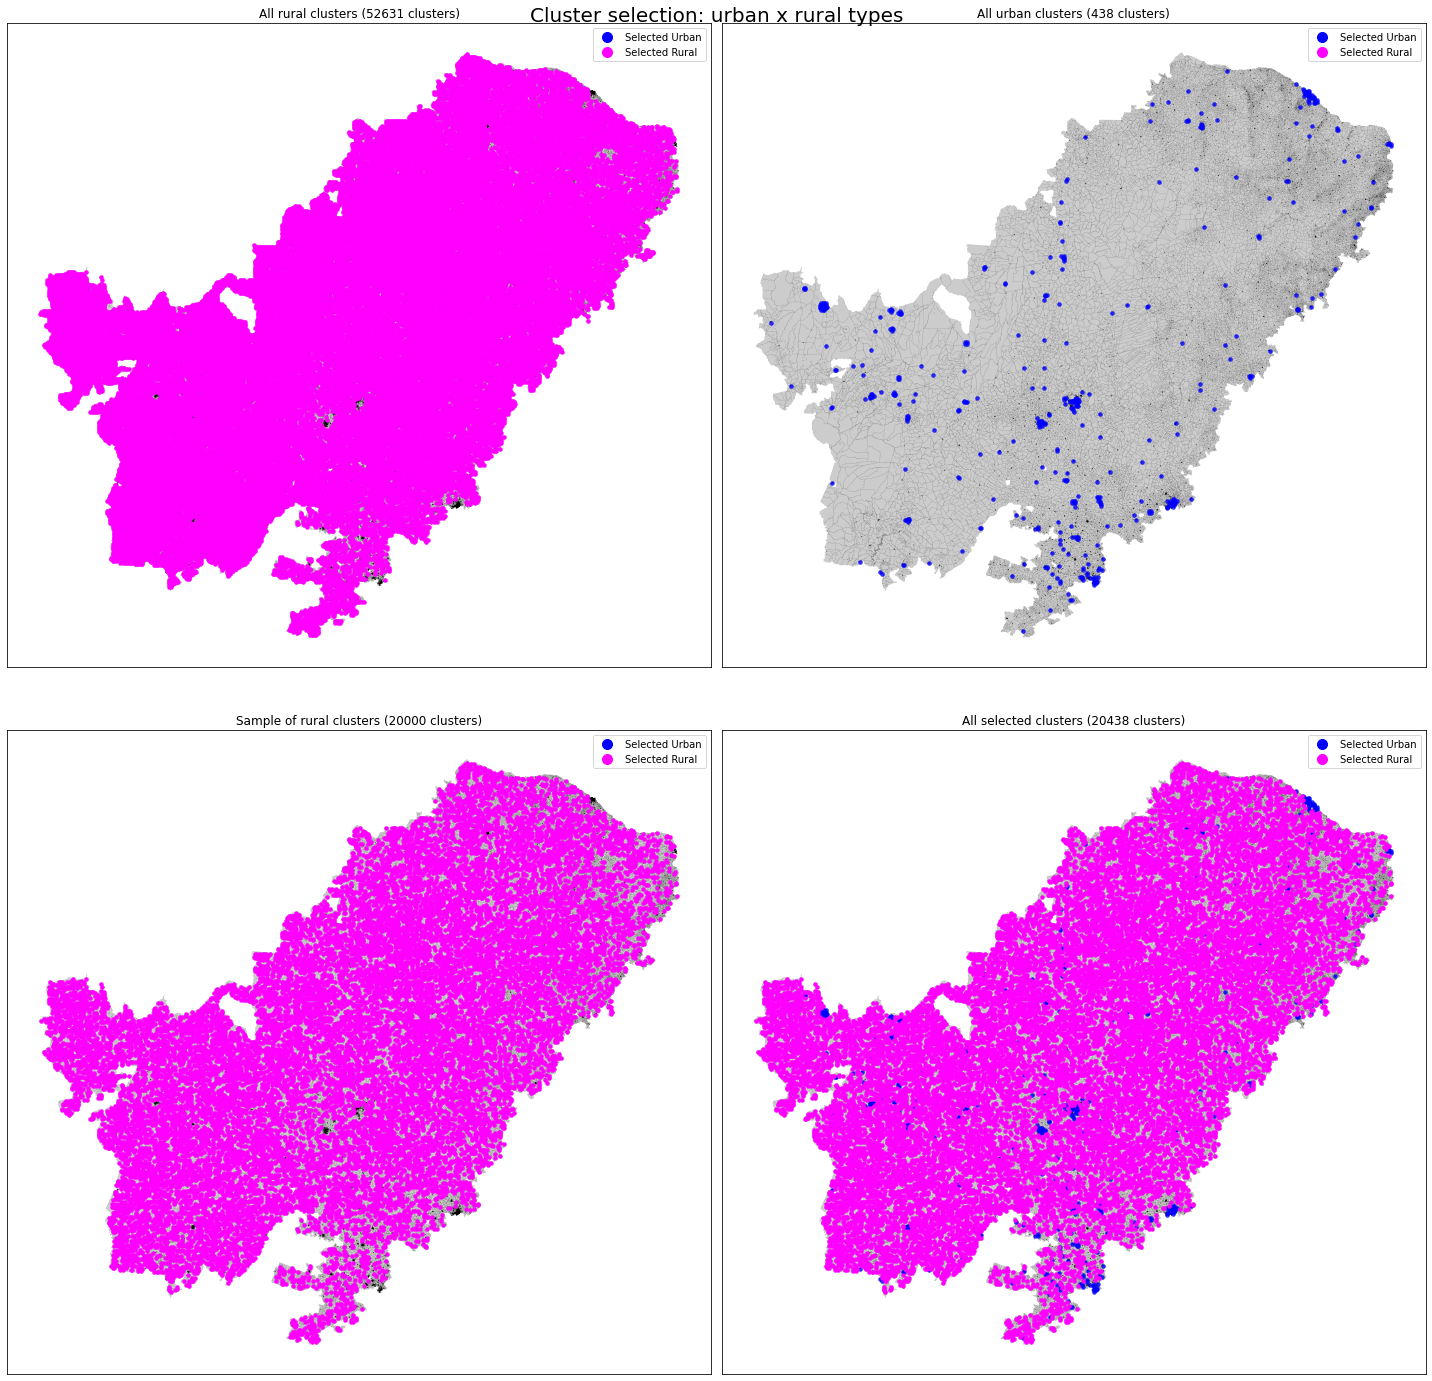

In [ ]:
geo_plot = change_projection(geo, METRIC_CRS, WGS84_CRS)

plt.figure(figsize = (20,20))
plt.suptitle("Cluster selection: urban x rural types", fontsize = 20)

ax = plt.subplot(2,2,1)
plt.title(f"All rural clusters ({df_dataset_rural.shape[0]} clusters)")
plot_data(ax, geo, df_selected = df_dataset_rural)
          
ax = plt.subplot(2,2,2)
plt.title(f"All urban clusters ({df_dataset_urban.shape[0]} clusters)")
plot_data(ax, geo, df_selected = df_dataset_urban)

ax = plt.subplot(2,2,3)
plt.title(f"Sample of rural clusters ({df_dataset_rural_sample.shape[0]} clusters)")
plot_data(ax, geo, df_selected = df_dataset_rural_sample)

ax = plt.subplot(2,2,4)
plt.title(f"All selected clusters ({df_dataset_balanced.shape[0]} clusters)")
plot_data(ax, geo, df_selected = df_dataset_balanced)

plt.tight_layout()


# Analise

In [ ]:
geo = change_projection(geo, WGS84_CRS, METRIC_CRS)

Área Nexus

In [ ]:
print(f"Area total da area NEUXS: {geo['area'].sum()/1e6/1e6} milhões de km2")

Area total da area NEUXS: 3.4219275722094546 milhões de km2


In [ ]:
print(f"Area total coberta pelos setores: {df_dataset.shape[0] * 6.7e3 ** 2/1e6/1e6} milhões de km2")

Area total coberta pelos setores: 2.3822674100000003 milhões de km2


In [ ]:
ratio_covered_nexus = df_dataset.shape[0] * 6.7e3 ** 2 / geo['area'].sum()
print(f"A razão entre a área selecionada e a áre total da área NEXUS é de {ratio_covered_nexus * 100}%")

A razão entre a área selecionada e a áre total da área NEXUS é de 69.61770404923645%


Setores urbanos

In [ ]:
print(f"Total de setores urbanos na area NEXUS: {geo[geo['TYPE'] == 'URBAN'].shape[0]}")
print(f"Area total de setores urbanos na area NEXUS: {geo[geo['TYPE'] == 'URBAN']['area'].sum()/1e6/1e3} mil km2")
print(f"Total de clusters urbanos: {df_dataset[df_dataset['TYPE'] == 'URBAN'].shape[0]}")
print(f"Area total coberta por clusters urbanos: {df_dataset[df_dataset['TYPE'] == 'URBAN'].shape[0] * 6.7e3 ** 2/1e6/1e3} mil km2")

Total de setores urbanos na area NEUXS: 78000
Area total de setores urbanos na area NEUXS: 40.75546494754274 mil km2
Total de clusters urbanos: 438
Area total coberta por clusters urbanos: 19.66182 mil km2


In [ ]:
print(f"Total de setores rurais na area NEXUS: {geo[geo['TYPE'] == 'RURAL'].shape[0]}")
print(f"Area total de setores rurais na area NEXUS: {geo[geo['TYPE'] == 'RURAL']['area'].sum()/1e6/1e6} milhões km2")
print(f"Total de clusters rurais: {df_dataset[df_dataset['TYPE'] == 'RURAL'].shape[0]}")
print(f"Area total coberta por clusters rurais: {df_dataset[df_dataset['TYPE'] == 'RURAL'].shape[0] * 6.7e3 ** 2/1e6/1e6} milhões km2")

Total de setores rurais na area NEUXS: 36244
Area total de setores rurais na area NEUXS: 3.381172107261912 milhões km2
Total de clusters rurais: 52631
Area total coberta por clusters rurais: 2.36260559 milhões km2


In [ ]:
geo_urbano = geo[geo["TYPE"] == "URBAN"]
geo_urbano.describe()

,Unnamed: 0,year,Cod_setor,Cod_municipio,Cod_estado,income,longevity,literacy,lat,lon,area
count,78000.000000,78000.0,7.800000e+04,7.800000e+04,78000.000000,78000.000000,78000.000000,78000.000000,7.800000e+04,7.800000e+04,7.800000e+04
mean,62542.255974,2010.0,3.415284e+14,3.415284e+06,33.996731,0.564509,0.746588,0.898834,-5.014457e+06,-1.595823e+06,5.225060e+05
std,32737.056005,0.0,1.064080e+14,1.064080e+06,10.656274,0.155502,0.159467,0.174702,5.871175e+05,6.994803e+05,3.451060e+06
min,0.000000,2010.0,1.100304e+14,1.100304e+06,11.000000,0.000000,0.000000,0.000000,-6.698104e+06,-2.673676e+06,4.096474e+02
25%,32744.000000,2010.0,2.510808e+14,2.510808e+06,25.000000,0.491334,0.700000,0.893369,-5.379785e+06,-2.175537e+06,7.314516e+04
50%,66677.500000,2010.0,3.137205e+14,3.137205e+06,31.000000,0.564704,0.766667,0.947652,-5.122704e+06,-1.753003e+06,1.422959e+05
75%,89876.250000,2010.0,3.549805e+14,3.549805e+06,35.000000,0.642672,0.833333,0.975554,-4.494237e+06,-8.698312e+05,3.467140e+05
max,114243.000000,2010.0,5.300108e+14,5.300108e+06,53.000000,1.000000,1.000000,1.000000,-3.909157e+06,-2.761718e+05,5.479942e+08


In [ ]:
geo_urbano = geo[geo["TYPE"] == "RURAL"]
geo_urbano.describe()

,Unnamed: 0,year,Cod_setor,Cod_municipio,Cod_estado,income,longevity,literacy,lat,lon,area
count,36244.000000,36244.0,3.624400e+04,3.624400e+04,36244.000000,36244.000000,36244.000000,36244.000000,3.624400e+04,3.624400e+04,3.624400e+04
mean,45455.597616,2010.0,2.961931e+14,2.961931e+06,29.485018,0.409149,0.722259,0.762509,-4.766996e+06,-1.212625e+06,9.328915e+07
std,30374.973251,0.0,9.183478e+13,9.183478e+05,9.169108,0.144755,0.186393,0.216386,5.739755e+05,6.037603e+05,2.320403e+08
min,54.000000,2010.0,1.100304e+14,1.100304e+06,11.000000,0.000000,0.000000,0.000000,-6.751169e+06,-2.682679e+06,1.166882e+01
25%,22456.750000,2010.0,2.308302e+14,2.308302e+06,23.000000,0.351956,0.700000,0.713481,-5.162488e+06,-1.653263e+06,5.097144e+06
50%,41980.500000,2010.0,2.804458e+14,2.804458e+06,28.000000,0.406927,0.766667,0.810870,-4.663008e+06,-1.113162e+06,3.397753e+07
75%,65181.250000,2010.0,3.129657e+14,3.129657e+06,31.000000,0.484132,0.816667,0.893702,-4.325988e+06,-7.174188e+05,9.203344e+07
max,114238.000000,2010.0,5.300108e+14,5.300108e+06,53.000000,1.000000,1.000000,1.000000,-3.906960e+06,-2.618583e+05,9.811193e+09


In [ ]:
ratio_urban_rural = geo[geo['TYPE'] == 'URBAN']['area'].sum()/geo[geo['TYPE'] == 'RURAL']['area'].sum()
print(f"A razão entre a área urbana total e a área rural total na Área NEXUS é de {ratio_urban_rural * 100}%")

A razão entre a área urbana total e a área rural total na Área NEXUS é de 1.2126511489607443%


Considerando todos os clusters urbanos, no pior caso, apenas 60% (threshold de 0.6 para seleção) de sua área total representa regiões urbanas.

Dessa forma, calcula-se que a área urbana total coberta pelos clusters é igual a 60% do total de clusters urbanos escolhidos, multiplicado pela área de um cluster

In [ ]:
urban_representation_worst_case = 438 * 0.6
print(f"A área total urbana representada pelos cluters, no pior caso é de {urban_representation_worst_case * 6.7 ** 2}")
print(f"Para manter a proporção entre urbanos e rurais seguindo a população total, " + 
      f"a amostra rural utilizada deve ser de {int(np.round(urban_representation_worst_case / ratio_urban_rural))} clusters")

A área total urbana representada pelos cluters, no pior caso é de 11797.092
Para manter a proporção entre urbanos e rurais seguindo a população total, a amostra rural utilizada deve ser de 21672 clusters
